# Imports and processes firn cores from SUMUP (2024) dataset

In [31]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from process_sumup_cores import *

from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, load all the data from the region of interest (Antarctica or Greenland). Set the paths appropriately so that it links to your own folder with sumup data.

In [2]:
# process sumup cores

data_path = "/home/nld4814/perm/cores/sumup/data/raw/"  # Update this to your SUMup data folder
output_path = "/home/nld4814/perm/cores/sumup/data/processed/"  # Path to save output files (can be same as data_path)
output_prefix = "sumup_550_830_density_depths"  # Will create _greenland.csv, _antarctica.csv, and _combined.csv files
domain = "greenland"

density_df, profile_names_df, references_df = load_sumup_data(data_path, domain)


Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references


We can select cores from the density dataset `density_df` by profile_key -- this gives us all the measurements of depth and density; the other information is identical. We can then plot it, and use the core's name for it's title by searching for the `profile_key` in the `profile_names_df` dataframe.

Text(0.5, 0, 'Density [kg/m3]')

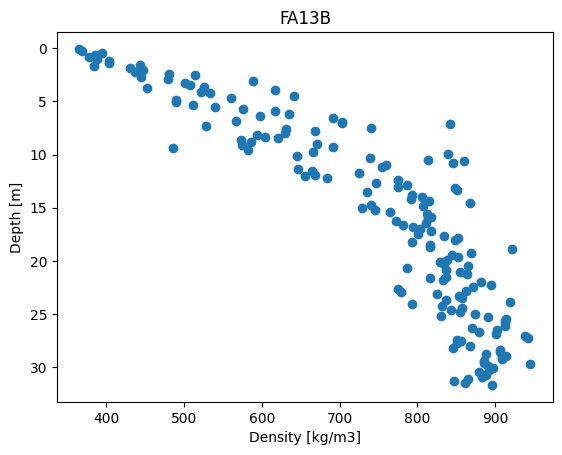

In [3]:
prof57 = density_df[density_df["profile_key"]==57]
plt.plot(prof57["density"],prof57["midpoint"], 'o')
plt.title(profile_names_df.loc[57]["profile"])
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

There are a few ways of going about choosing depth to 550 kg/m3 and 830 kg/m3. We are going to take the easiest option: look for the first instance where the depth exceeds the target density, and we interpolate between that point and the point previous to get the depth. We could also fit a curve to the depth-density profile, and then select a depth from there. We cannot just use a built in funciton like `interp_1d` because the densities often do not monotonically increase with depth

In [4]:
# let's simplify the structure of our dataframe so we can find the depths of the target densities more easily

prof57 = density_df[density_df["profile_key"]==57]
prof57 = prof57.drop(columns=['reference_key', 'method_key', 'start_depth', 'stop_depth', 'error', 'region'])
prof57 = prof57.rename(columns={"midpoint": "depth"})
prof57.head()

,profile_key,timestamp,latitude,longitude,elevation,depth,density
0,57,2013-04-08,66.1812,-39.043499,1563.0,0.220,368.42
1,57,2013-04-08,66.1812,-39.043499,1563.0,1.175,402.91
2,57,2013-04-08,66.1812,-39.043499,1563.0,14.710,740.07
3,57,2013-04-08,66.1812,-39.043499,1563.0,0.425,394.59
4,57,2013-04-08,66.1812,-39.043499,1563.0,0.630,385.00


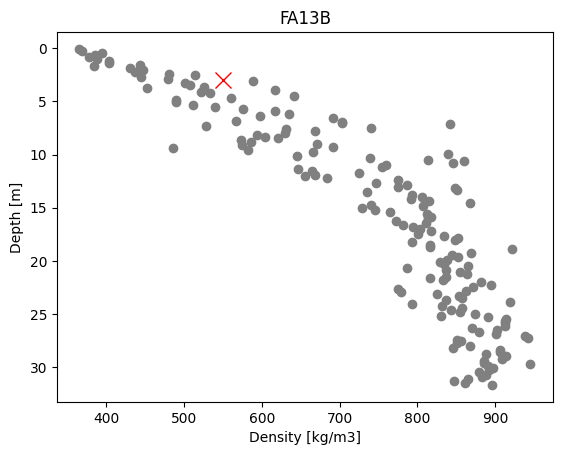

In [5]:
# an example for a target density of 550
df = prof57.copy()
failed = False

target_density = 550

depth = np.array(df.depth.values)
density = np.array(df.density.values)

# Sort by depth - should monotonically increase (but density likely won't)
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is reached
if np.max(density_sorted) < target_density:
    print("Core too shallow, do not proceed")
    failed = True
    #return np.nan

if not failed:
    # Find first point where target density is reached or exceeded
    idx = np.where(density_sorted >= target_density)[0]

    first_idx = idx[0]
    
    # If first measurement already exceeds target, interpolate previous depth is zero. we choose 350 to be the density at the surface.
    if first_idx == 0:
        prev_depth = 0
        prev_density = 350
    else:
        prev_depth = depth_sorted[first_idx - 1]
        prev_density = density_sorted[first_idx - 1]
    
    curr_depth = depth_sorted[first_idx]
    curr_density = density_sorted[first_idx]
        
    # Weighted interpolatation based on distance and density difference
    interpolated_depth = prev_depth + (target_density - prev_density) * (curr_depth - prev_depth) / (curr_density - prev_density)

    interpolated_depth = round(interpolated_depth,2)

    #now let's plot it and make sure it looks reasonable

    plt.plot(df["density"],df["depth"], 'o', color="grey")
    plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Interpolated Depth at 550 kg/m3')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth [m]")
    plt.xlabel("Density [kg/m3]")

    plt.title(profile_names_df.loc[57]["profile"])



We could also choose to fit a curve to the data and then select a density from there. In general, a logarithmic or power law fit does well with depth-density datasets.

First we define the fits we could use, and the minimization of that fit with a target (for finding the depth at target density later on)

In [6]:
def power_law(x, a, b, c):
    return a * x**b + c

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

models = [
    (power_law, "Power law", "a*x^b + c", 'blue'),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green')
]

Then we fit the models to the data. Let's start with the logarithmic curve

In [7]:
model = models[1]
func = model[0]
color = model[3]

fitted_params = {}

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

popt, pcov = curve_fit(func, depth, density)

# Store parameters with a simple key
model_name = "logarithmic"
fitted_params[model_name] = popt

# Calculate fitted values
density_smooth = func(depth_smooth, *popt)


Now we can find the density at the target depth using the fit we just calculated

In [8]:
try:
    depth_at_rho = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt, target_density)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho = np.nan
    failed = int(1)



And plot them

Text(0.5, 1.0, 'FA13B')

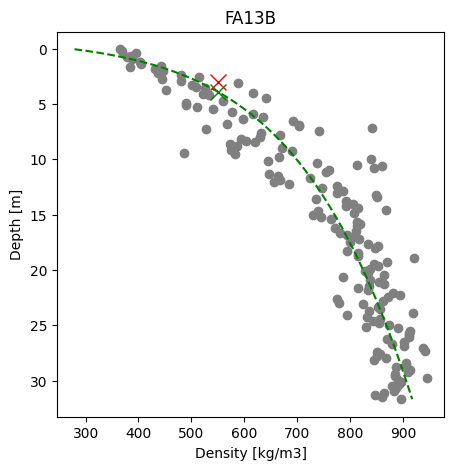

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(density, depth, 'o', color='grey', label='Core Observations')
ax.plot(density_smooth, depth_smooth, '--', color=color, label=f'Fitted {model[1]}')
ax.plot(target_density, depth_at_rho, 'gx', markersize=12, label='Model fit')
plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Point interpolation')
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

plt.title(profile_names_df.loc[57]["profile"])


In processing thes SUMup dataset, we choose to try to do a logarithmic fit; if that fit fails or if the r2 of that fit is <0.9, then we do the first index approach.

process_sumup_main()

First we define the fits we could use, and the minimization of that fit with a target (for finding the depth at target density later on

In [10]:
def power_law(x, a, b, c):
    return a * x**b + c

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

models = [
    (power_law, "Power law", "a*x^b + c", 'blue'),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green')
]

Then we fit the model to the data. Let's start with the logarithmic curve

In [11]:
model = models[1]
func = model[0]
color = model[3]

fitted_params = {}

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

popt, pcov = curve_fit(func, depth, density)

# Store parameters with a simple key
model_name = "logarithmic"
fitted_params[model_name] = popt

# Calculate fitted values
density_smooth = func(depth_smooth, *popt)


Now we can find the density at the target depth using the fit we just calculated

In [12]:
try:
    depth_at_rho = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt, target_density)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho = np.nan
    failed = int(1)



And plot them

Text(0.5, 1.0, 'FA13B')

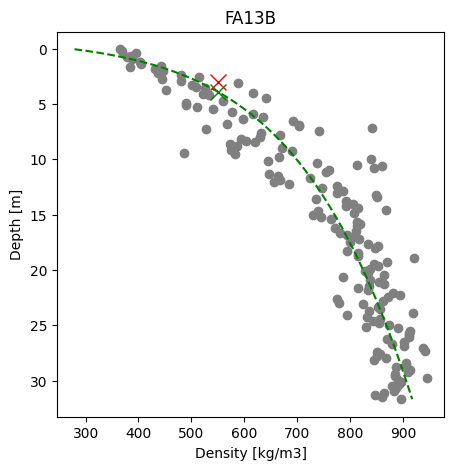

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(density, depth, 'o', color='grey', label='Core Observations')
ax.plot(density_smooth, depth_smooth, '--', color=color, label=f'Fitted {model[1]}')
ax.plot(target_density, depth_at_rho, 'gx', markersize=12, label='Model fit')
plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Point interpolation')
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

plt.title(profile_names_df.loc[57]["profile"])


We can do the same process for the power law and see how that differs

Text(0.5, 1.0, 'FA13B')

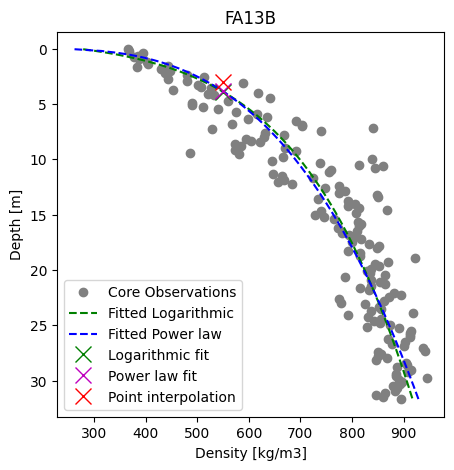

In [14]:
model = models[0]
func = model[0]
color = model[3]

fitted_params = {}

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

popt, pcov = curve_fit(func, depth, density)

# Store parameters with a simple key
model_name = model[1]
fitted_params[model_name] = popt

# Calculate fitted values
density_smooth_power = func(depth_smooth, *popt)

try:
    depth_at_rho_power = brentq(
        power_law_minimization,
        depth.min(),
        depth.max(),
        args=(*popt, target_density)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho = np.nan
    failed = int(1)

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(density, depth, 'o', color='grey', label='Core Observations')
ax.plot(density_smooth, depth_smooth, '--', color=models[1][3], label=f'Fitted {models[1][1]}')
ax.plot(density_smooth_power, depth_smooth, '--', color=models[0][3], label=f'Fitted {models[0][1]}')
ax.plot(target_density, depth_at_rho, 'gx', markersize=12, label='Logarithmic fit')
ax.plot(target_density, depth_at_rho_power, 'mx', markersize=12, label='Power law fit')
plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Point interpolation')
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

plt.title(profile_names_df.loc[57]["profile"])



In processing the SUMup dataset, we choose to try to do a logarithmic fit; if that fit fails or if the r2 of that fit is <0.8, then we do a power law; otherwise we do the first index approach. 

## Now we can do the whole sumup processing! The data paths should be set in `process_sumup_cores.py` and will save automatically.

In [34]:
#do the sumup processing

process_sumup_main()

Loading SUMup data files...
Loading Greenland data only


Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references
Processing individual cores...
Processed 100/1541 profiles...
Processed 200/1541 profiles...
Processed 300/1541 profiles...
Processed 400/1541 profiles...
Processed 500/1541 profiles...
Processed 600/1541 profiles...
Processed 700/1541 profiles...
Processed 800/1541 profiles...
Processed 900/1541 profiles...
Processed 1000/1541 profiles...
Processed 1100/1541 profiles...
Processed 1200/1541 profiles...
Processed 1300/1541 profiles...
Processed 1400/1541 profiles...
Processed 1500/1541 profiles...
Processed 1541 profiles total

Summary:
Total cores processed: 140
Cores reaching 550 kg/m³: 140
Cores reaching 830 kg/m³: 40
Cores reaching both densities: 40

Filtering results:
Total cores processed: 140
Cores reaching 550 kg/m³: 140
Cores filtered out: 0
greenland cores: 140
  - Reaching 550 kg/m³: 140
  - Reaching 830 kg/m³: 40

Sample of processed cores:
    core_name       date  depth_to_550 